# Установка и изучение датасета

In [49]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kaustubhdikshit/neu-surface-defect-database/versions/1


In [50]:
import os
base_path = '/root/.cache/kagglehub/datasets/kaustubhdikshit/neu-surface-defect-database/versions/1'

train_dir = os.path.join(base_path, 'NEU-DET', 'train')
val_dir = os.path.join(base_path, 'NEU-DET', 'validation')
train_files = []
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.endswith('.jpg'):
            file = os.path.join(dirname, filename)
            train_files.append(file)

print(f"Number of training files: {len(train_files)}")

val_files = []
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        if filename.endswith('.jpg'):
            file = os.path.join(dirname, filename)
            val_files.append(file)

print(f"Number of validation files: {len(val_files)}")


Number of training files: 1440
Number of validation files: 360


In [3]:
!pip install pandas==2.0.3 Pillow==10.1.0 pytorch-ignite==0.4.13 albumentations==1.3.1 torch==2.0.0 torchvision==0.15.1 scikit-learn==1.2.2

In [51]:
import base64
import os
from glob import glob

import albumentations as A
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.core.display import HTML
from PIL import Image
from albumentations.pytorch import ToTensorV2 as ToTensor
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.resnet import resnet18

In [52]:
MODEL_BIN = 'pytorch_model.bin'

# написали название как категорикал переменные
label_name_to_label_id = {'in': 0, 'pi': 1, 'cr': 2, 'pa': 3, 'sc': 4, 'ro': 5}
label_id_to_label_name = {l_id: l_name for l_name, l_id in label_name_to_label_id.items()}


full_df = pd.DataFrame(dict(file=train_files + val_files))
full_df['label_name'] = full_df['file'].map(lambda file: os.path.basename(file)).str[:2].str.lower()


full_df['label'] = full_df['label_name'].map(label_name_to_label_id)
# print(full_df[full_df['label'].isnull()].head())
assert full_df['label'].notnull().all()

In [53]:
full_df.sample(10).head(10)

,file,label_name,label
453,/root/.cache/kagglehub/datasets/kaustubhdikshi...,ro,5
1445,/root/.cache/kagglehub/datasets/kaustubhdikshi...,pi,1
854,/root/.cache/kagglehub/datasets/kaustubhdikshi...,sc,4
1269,/root/.cache/kagglehub/datasets/kaustubhdikshi...,pa,3
618,/root/.cache/kagglehub/datasets/kaustubhdikshi...,in,0
1702,/root/.cache/kagglehub/datasets/kaustubhdikshi...,cr,2
261,/root/.cache/kagglehub/datasets/kaustubhdikshi...,ro,5
1180,/root/.cache/kagglehub/datasets/kaustubhdikshi...,cr,2
1259,/root/.cache/kagglehub/datasets/kaustubhdikshi...,pa,3
845,/root/.cache/kagglehub/datasets/kaustubhdikshi...,sc,4


In [7]:
len(full_df)

1800

In [54]:
full_df['label_name'].value_counts()

,count
label_name,
pi,300
ro,300
in,300
sc,300
cr,300
pa,300


In [55]:
def image_formatter(img_file):
    with open(img_file, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode()
        return f'<img width="150" src="data:image/png;base64,{encoded_string}">'

def display_frame(df: pd.DataFrame):
    return display(
        HTML(
            df.to_html(
                formatters={
                    'file': image_formatter,
                },
                escape=False,
                index=True,
            )
        )
    )

# Создание загрузчиков данных для эффективного обучения и тестирования модели

In [56]:
train_df = full_df[:len(train_files)]
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=4242)
test_df = full_df[len(train_files):].copy()

In [57]:

batch_size = 64
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# from torchvision import transforms as transforms
# from torchvision.transforms import v2 as transforms
# from torchvision.transforms.v2 import Resize

# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
# #     transforms.Resize((200, 200)),
# #     transforms.Normalize(mean=mean, std=std),
#     transforms.PILToTensor(),
# ])

# Берем разный масштаб, ракурсы, яркость чтобы модель мог понимать разные случаи
train_transforms = A.Compose(
    [
        A.Resize(224, 224),

        # Меняет масштаб рандомно потом делает его 224х224.
         A.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0)),


        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HorizontalFlip(p=0.5),


        A.CoarseDropout(max_height=32, max_width=32),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.5),

        A.Normalize(mean=mean, std=std),
        ToTensor(),
    ]
)
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=mean, std=std),
        ToTensor(),
    ]
)


class NEUDataset(Dataset):
    def __init__(self, df, dataset_transforms):
        self.df = df
        self.dataset_transforms = dataset_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file, label = self.df[['file', 'label']].iloc[idx].values

        category = torch.as_tensor(label)  # Преобразуем метку в тензор PyTorch

        img = np.array(Image.open(file))  # Открываем изображение по указанному пути и превращаем его в массив
        img = self.dataset_transforms(image=img)['image']  # Применяем преобразования к изображению
        return img, category


train_ds = NEUDataset(train_df, train_transforms)
val_ds = NEUDataset(val_df, val_transforms)
test_ds = NEUDataset(test_df, val_transforms)

num_workers = 0

# Создаем DataLoader для каждого набора данных
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers)
# перемешивает данные и разбивает их на мини-батчи для тренировки

val_loader = DataLoader(val_ds, shuffle=False, batch_size=batch_size, num_workers=num_workers)
# не перемешивает данные, чтобы проверка была постоянной

test_loader = DataLoader(test_ds, shuffle=False, batch_size=batch_size, num_workers=num_workers)
# такой же как и валидационный


# Классификатор и предобученная модель

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NeuClassifier(nn.Module):

    def __init__(self, n_classes: int, device='cpu'):
        super(NeuClassifier, self).__init__()

        self.device = device
        self.resnet = resnet18(pretrained=True) #наша претрейнед модель
        #использует слои до avgpool
        self.backbone = create_feature_extractor(self.resnet, return_nodes=["avgpool"])

        self.backbone.to(device)
        self.post = nn.Linear(in_features=512, out_features=n_classes)
        self.post.to(device)

    def forward(self, image):
        x = self.backbone(image.to(self.device))
        x = x["avgpool"]
        x = torch.squeeze(torch.squeeze(x, axis=2), axis=2)
        x = self.post(x)
        return torch.nn.functional.log_softmax(x, dim=-1)
# Для сохранения, если потом нужно будет это использовать
    def to_disk(self, local_model_dir: str) -> None:
        torch.save(self.state_dict(), local_model_dir + MODEL_BIN, pickle_protocol=4)
# Извлекает данные
    @classmethod
    def from_disk(cls, local_model_dir: str, n_classes: int, device: str):
        state_dict = torch.load(local_model_dir + MODEL_BIN, map_location=device)
        model = cls(n_classes, device)
        model.load_state_dict(state_dict, strict=True)
        return model

# Тренировка и оценка модели

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

# Гиперпараметры
num_epochs = 5
learning_rate = 0.0007
weight_decay = 1e-4

model = NeuClassifier(n_classes=len(label_name_to_label_id), device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Создание тренера и валидатора
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(),
    "nll": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Каждые 10 мини батчей  показываем лосс
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

# Логирование после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch_results(trainer):
    evaluator.run(train_loader)
    train_metrics = evaluator.state.metrics

    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics


    print(f"Epoch {trainer.state.epoch} of {num_epochs}")
    print(f"  training loss (in-iteration): {train_metrics['nll']:.6f}")
    print(f"  validation accuracy: {val_metrics['accuracy'] * 100:.2f} %")

trainer.run(train_loader, max_epochs=num_epochs, seed=333)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/ignite/engine/engine.py:836: UserWarning: Argument seed is deprecated. It will be removed in 0.4.14. Please, use torch.manual_seed or ignite.utils.manual_seed
  warnings.warn(


Epoch[1] Loss: 0.37
Epoch 1 of 5
  training loss (in-iteration): 0.924444
  validation accuracy: 91.67 %
Epoch[2] Loss: 0.31
Epoch[2] Loss: 0.37
Epoch 2 of 5
  training loss (in-iteration): 0.662389
  validation accuracy: 87.85 %
Epoch[3] Loss: 0.24
Epoch[3] Loss: 0.12
Epoch 3 of 5
  training loss (in-iteration): 0.256083
  validation accuracy: 96.18 %
Epoch[4] Loss: 0.23
Epoch[4] Loss: 0.26
Epoch 4 of 5
  training loss (in-iteration): 0.165874
  validation accuracy: 93.75 %
Epoch[5] Loss: 0.15
Epoch[5] Loss: 0.13
Epoch 5 of 5
  training loss (in-iteration): 0.112364
  validation accuracy: 96.53 %


State:
	iteration: 90
	epoch: 5
	epoch_length: 18
	max_epochs: 5
	output: 0.12529268860816956
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [18]:
model.eval()

NeuClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [19]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# images, labels = dataiter.next()
pred_arr = []
pred_name_arr = []

# iterating on the dataset to predict the output
for batch in test_loader:
    images, labels = batch # Извлекаем изображения и метки из текущего батча
    predictions = torch.exp(model(images)) # C помощью экспоненты  предиктим
    predictions = predictions.to('cpu').detach().numpy().squeeze()
    pred_ids = np.argmax(predictions, -1)
    for pred_id in pred_ids:
        pred_arr.append(pred_id)
        pred_name_arr.append(label_id_to_label_name[pred_id])

test_df['prediction_name'] = pred_name_arr
test_df['prediction'] = pred_arr

# Результат натренированной модели

In [47]:
from sklearn.metrics import classification_report

report = classification_report(
    test_df['label'],
    test_df['prediction'],
    target_names=list(label_id_to_label_name.values())
)

print(report)


              precision    recall  f1-score   support

          in       0.97      0.95      0.96        60
          pi       0.96      0.40      0.56        60
          cr       0.95      1.00      0.98        60
          pa       0.82      0.98      0.89        60
          sc       0.89      0.98      0.94        60
          ro       0.80      1.00      0.89        60

    accuracy                           0.89       360
   macro avg       0.90      0.89      0.87       360
weighted avg       0.90      0.89      0.87       360



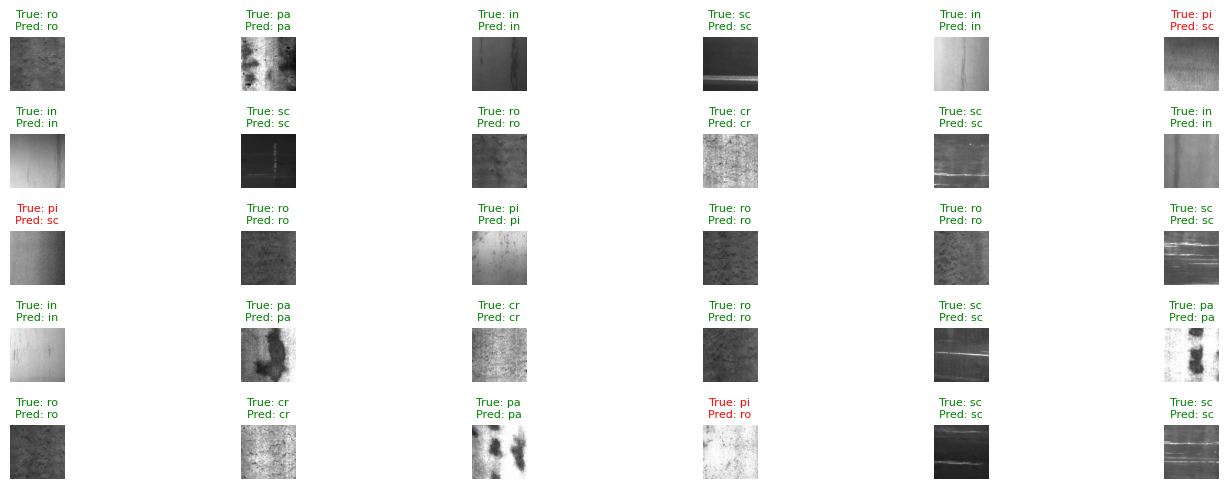

In [42]:
import matplotlib.pyplot as plt

def display_predictions_grid(dataframe, n=30, rows=5, cols=6):
    sample = dataframe.sample(n=n)
    files = sample['file'].values
    true_labels = sample['label_name'].values
    predicted_labels = sample['prediction_name'].values

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(files):
            ax.axis('off')
            continue


        img = plt.imread(files[i])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}",
                     fontsize=8, color="green" if true_labels[i] == predicted_labels[i] else "red")

    plt.tight_layout()
    plt.show()

display_predictions_grid(test_df, n=30, rows=5, cols=6)


In [22]:
print((test_df['label'] != test_df['prediction']).sum())
confusion_matrix(test_df['label'], test_df['prediction'])

41


array([[57,  1,  0,  0,  2,  0],
       [ 2, 24,  3, 13,  4, 14],
       [ 0,  0, 60,  0,  0,  0],
       [ 0,  0,  0, 59,  1,  0],
       [ 0,  0,  0,  0, 59,  1],
       [ 0,  0,  0,  0,  0, 60]])

# Улучшенная модель

In [58]:
class EnhancedModel(nn.Module):
    def __init__(self, n_classes: int, device='cpu'):
        super(EnhancedModel, self).__init__()
        self.device = device

        # Предобученная ResNet18
        self.resnet = resnet18(pretrained=True)


        self.backbone = nn.Sequential(
            nn.Flatten(),                  # Преобразование признаков в вектор
            nn.Linear(512, 256),           # Полностью соединённый слой
            nn.BatchNorm1d(256),           # Batch Normalization
            nn.ReLU(),                     # Активация
            nn.Dropout(0.5),               # Dropout
            nn.Linear(256, n_classes)      # Выходной слой
        )
        self.resnet.fc = self.backbone

        self.resnet.to(device)

    def forward(self, x):
        return self.resnet(x)


In [59]:
# Гиперпараметры
num_epochs = 5
learning_rate = 0.0007
weight_decay = 1e-4

enhanced_model = EnhancedModel(n_classes=len(label_name_to_label_id), device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(enhanced_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = create_supervised_trainer(enhanced_model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(),
    "nll": Loss(criterion)
}
evaluator = create_supervised_evaluator(enhanced_model, metrics=val_metrics, device=device)

@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch_results(trainer):
    evaluator.run(train_loader)
    train_metrics = evaluator.state.metrics

    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics

    print(f"Epoch {trainer.state.epoch} of {num_epochs}")
    print(f"  training loss: {train_metrics['nll']:.6f}")
    print(f"  validation accuracy: {val_metrics['accuracy'] * 100:.2f} %")

trainer.run(train_loader, max_epochs=num_epochs, seed=333)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/ignite/engine/engine.py:836: UserWarning: Argument seed is deprecated. It will be removed in 0.4.14. Please, use torch.manual_seed or ignite.utils.manual_seed
  warnings.warn(


Epoch[1] Loss: 0.64
Epoch 1 of 5
  training loss: 1.823295
  validation accuracy: 41.67 %
Epoch[2] Loss: 0.54
Epoch[2] Loss: 0.48
Epoch 2 of 5
  training loss: 0.313314
  validation accuracy: 89.93 %
Epoch[3] Loss: 0.30
Epoch[3] Loss: 0.19
Epoch 3 of 5
  training loss: 0.582055
  validation accuracy: 78.47 %
Epoch[4] Loss: 0.32
Epoch[4] Loss: 0.19
Epoch 4 of 5
  training loss: 0.060457
  validation accuracy: 98.96 %
Epoch[5] Loss: 0.33
Epoch[5] Loss: 0.26
Epoch 5 of 5
  training loss: 0.100048
  validation accuracy: 95.49 %


State:
	iteration: 90
	epoch: 5
	epoch_length: 18
	max_epochs: 5
	output: 0.2579135000705719
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [60]:
def predict_image(image_path, model, device):
    model.eval()
    with torch.no_grad():
        img = Image.open(image_path).convert("RGB")
        transformed_img = val_transforms(image=np.array(img))['image'].unsqueeze(0).to(device)


        output = model(transformed_img)
        pred_label = torch.argmax(output, dim=1).item()
        pred_label_name = label_id_to_label_name[pred_label]
        return pred_label, pred_label_name



# Результаты

In [61]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []
for batch in test_loader:
    images, labels = batch
    outputs = enhanced_model(images.to(device))
    preds = outputs.argmax(dim=1).cpu().numpy()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

report = classification_report(y_true, y_pred, target_names=list(label_id_to_label_name.values()))
print(report)



              precision    recall  f1-score   support

          in       0.85      1.00      0.92        60
          pi       1.00      0.77      0.87        60
          cr       0.97      1.00      0.98        60
          pa       0.98      1.00      0.99        60
          sc       1.00      1.00      1.00        60
          ro       1.00      1.00      1.00        60

    accuracy                           0.96       360
   macro avg       0.97      0.96      0.96       360
weighted avg       0.97      0.96      0.96       360



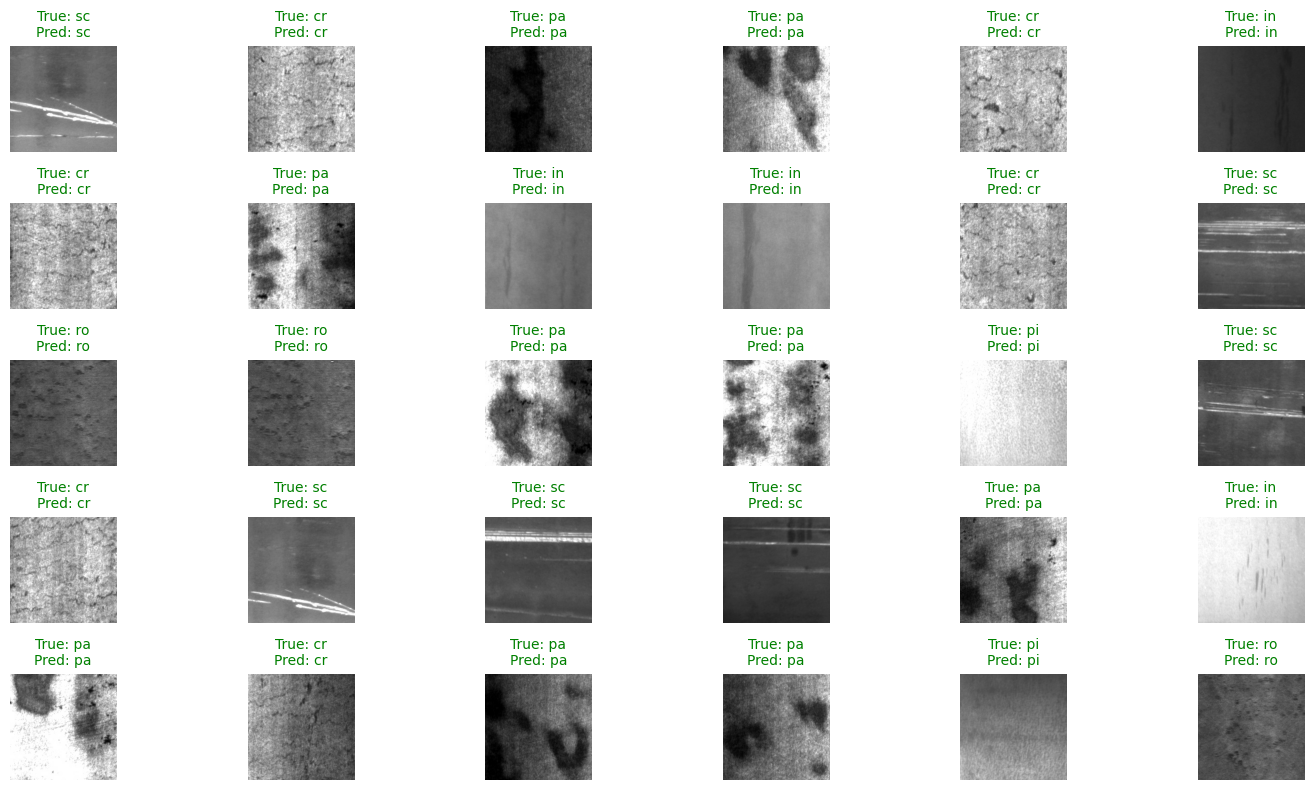

In [62]:
import matplotlib.pyplot as plt
from PIL import Image

def display_predictions_grid(dataframe, model, device, n=15, rows=3, cols=5):

    sample = dataframe.sample(n=n)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(sample):
            ax.axis("off")
            continue

        img_path = sample['file'].iloc[i]
        true_label_name = sample['label_name'].iloc[i]
        pred_label, pred_label_name = predict_image(img_path, model, device)
        img = Image.open(img_path)
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        true_text = f"True: {true_label_name}"
        pred_text = f"Pred: {pred_label_name}"
        color = "green" if true_label_name == pred_label_name else "red"

        ax.set_title(f"{true_text}\n{pred_text}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
display_predictions_grid(test_df, enhanced_model, device, n=30, rows=5
                         , cols=6)
